keras --> pytorch conversion of VED 2

In [1]:


import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

2022-10-31 16:21:30.732323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob


In [3]:
def sampling_to(mean,log_var):
    
    """
    Reparameterization trick by sampling from an isotropic unit Gaussian in pytorch.
    author: G. Behrens
    """
    z_mean=mean
    z_log_var =log_var
    batch= z_mean.size(dim=0) #K.shape(z_mean)[0]
    dim=z_mean.size(dim=1)
    eps=to.normal(mean=0.0,std=1.0,size=(batch,dim))
    sampling_prob=z_mean+to.exp(0.5*z_log_var)*eps
    return sampling_prob

In [4]:
#define some hyperparameter 
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(113) # CBRAIN output node size 


# network parameters
latent_dim=10
intermediate_dim = 411  
batch_size = 9047 
kl_weight=5.2488877955554e-05
lr_init=0.0004416253215368389
act='elu'

input_shape = (original_dim_input,)
decoder_input_shape=(latent_dim,)
out_shape=(original_dim_output,)

In [8]:
# build VED 2 in Keras 

input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation=act)(input_lay)
x_1 =Dense(intermediate_dim, activation=act)(x_0)
x_2 =Dense(intermediate_dim/2, activation=act)(x_1)
x_3 =Dense(intermediate_dim/4, activation=act)(x_2)
x_4 =Dense(intermediate_dim/8, activation=act)(x_3)
x_5 =Dense(intermediate_dim/16, activation=act)(x_4)
z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_lay, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
    
input_decoder=Input(shape=decoder_input_shape, name='decoder_input')
x_0 =Dense(intermediate_dim/16, activation=act)(input_decoder)
x_1 =Dense(intermediate_dim/8, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/2, activation=act)(x_2)
x_4 =Dense(intermediate_dim, activation=act)(x_3)
x_5 =Dense(intermediate_dim, activation=act)(x_4)


outputs_1= Dense(original_dim_output,activation=act)(x_5)
outputs_A = Dense(104,activation='linear')(outputs_1)
outputs_B = Dense(9,activation='relu')(outputs_1)
outputs= Concatenate()([outputs_A,outputs_B])
 
    
# instantiate encoder model
decoder = Model(input_decoder, outputs, name='decoder')
decoder.summary()
decoder_outputs=decoder(encoder(input_lay)[2])
VED_2=Model(input_lay,decoder_outputs, name='VED')
VED_2.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 109)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 411)          45210       ['encoder_input[0][0]']          
                                                                                                  
 dense_16 (Dense)               (None, 411)          169332      ['dense_15[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 205)          84460       ['dense_16[0][0]']               
                                                                                            

In [23]:
# load weights into keras model 
VED_2.load_weights('real_geography/VEDs/VED_2/VED_2_weights.h5',by_name=True)
VED_2.summary()
VED_2_weights=VED_2.get_weights()



Model: "VED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 encoder (Functional)        [(None, 10),              327087    
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 113)               341456    
                                                                 
Total params: 668,543
Trainable params: 668,543
Non-trainable params: 0
_________________________________________________________________


load pytorch 

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
# build Encoder 
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.X_1=nn.Linear(109,VED_2_weights[0].shape[1])
        self.X_2=nn.Linear(VED_2_weights[0].shape[1],VED_2_weights[2].shape[1])
        self.X_3=nn.Linear(VED_2_weights[2].shape[1],VED_2_weights[4].shape[1])
        self.X_4=nn.Linear(VED_2_weights[4].shape[1],VED_2_weights[6].shape[1])
        self.X_5=nn.Linear(VED_2_weights[6].shape[1],VED_2_weights[8].shape[1])
        self.X_6=nn.Linear(VED_2_weights[8].shape[1],VED_2_weights[10].shape[1])
        self.z_mean=nn.Linear(VED_2_weights[10].shape[1],VED_2_weights[12].shape[1])
        self.z_log_var=nn.Linear(VED_2_weights[10].shape[1],VED_2_weights[14].shape[1])
        
        

           
    def forward(self,x):
        
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x_1=self.z_mean(x)
        x_2=self.z_log_var(x)
        x=sampling_to(x_1,x_2)
            
        return x

        
        
#build Decoder         
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.X_1=nn.Linear(VED_2_weights[14].shape[1],VED_2_weights[16].shape[1])
        self.X_2=nn.Linear(VED_2_weights[16].shape[1],VED_2_weights[18].shape[1])
        self.X_3=nn.Linear(VED_2_weights[18].shape[1],VED_2_weights[20].shape[1])
        self.X_4=nn.Linear(VED_2_weights[20].shape[1],VED_2_weights[22].shape[1])
        self.X_5=nn.Linear(VED_2_weights[22].shape[1],VED_2_weights[24].shape[1])
        self.X_6=nn.Linear(VED_2_weights[24].shape[1],VED_2_weights[26].shape[1])
        self.X_7=nn.Linear(VED_2_weights[26].shape[1],VED_2_weights[28].shape[1])
        self.X_8=nn.Linear(VED_2_weights[28].shape[1],VED_2_weights[30].shape[1])
        self.X_9=nn.Linear(VED_2_weights[28].shape[1],VED_2_weights[32].shape[1])


    def forward(self,x):
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x=F.elu(self.X_7(x))

        x_1=self.X_8(x)
        x_2=F.relu(self.X_9(x))
        x=to.cat([x_1,x_2],1)

            
        return x

        
        
      
    
        



        


In [26]:
# initialize Encoder 2, Decoder 2 
Encoder_2=Encoder()
Decoder_2=Decoder()

print(Encoder_2)
print(Decoder_2)



Encoder(
  (X_1): Linear(in_features=109, out_features=411, bias=True)
  (X_2): Linear(in_features=411, out_features=411, bias=True)
  (X_3): Linear(in_features=411, out_features=205, bias=True)
  (X_4): Linear(in_features=205, out_features=102, bias=True)
  (X_5): Linear(in_features=102, out_features=51, bias=True)
  (X_6): Linear(in_features=51, out_features=25, bias=True)
  (z_mean): Linear(in_features=25, out_features=10, bias=True)
  (z_log_var): Linear(in_features=25, out_features=10, bias=True)
)
Decoder(
  (X_1): Linear(in_features=10, out_features=25, bias=True)
  (X_2): Linear(in_features=25, out_features=51, bias=True)
  (X_3): Linear(in_features=51, out_features=102, bias=True)
  (X_4): Linear(in_features=102, out_features=205, bias=True)
  (X_5): Linear(in_features=205, out_features=411, bias=True)
  (X_6): Linear(in_features=411, out_features=411, bias=True)
  (X_7): Linear(in_features=411, out_features=113, bias=True)
  (X_8): Linear(in_features=113, out_features=104, bi

In [27]:
# load weights into Encoder 2

Encoder_2.X_1.weight.data=to.from_numpy(np.transpose(VED_2_weights[0]))
Encoder_2.X_1.bias.data=to.from_numpy(np.transpose(VED_2_weights[1]))
Encoder_2.X_2.weight.data=to.from_numpy(np.transpose(VED_2_weights[2]))
Encoder_2.X_2.bias.data=to.from_numpy(np.transpose(VED_2_weights[3]))
Encoder_2.X_3.weight.data=to.from_numpy(np.transpose(VED_2_weights[4]))
Encoder_2.X_3.bias.data=to.from_numpy(np.transpose(VED_2_weights[5]))
Encoder_2.X_4.weight.data=to.from_numpy(np.transpose(VED_2_weights[6]))
Encoder_2.X_4.bias.data=to.from_numpy(np.transpose(VED_2_weights[7]))
Encoder_2.X_5.weight.data=to.from_numpy(np.transpose(VED_2_weights[8]))
Encoder_2.X_5.bias.data=to.from_numpy(np.transpose(VED_2_weights[9]))
Encoder_2.X_6.weight.data=to.from_numpy(np.transpose(VED_2_weights[10]))
Encoder_2.X_6.bias.data=to.from_numpy(np.transpose(VED_2_weights[11]))
Encoder_2.z_mean.weight.data=to.from_numpy(np.transpose(VED_2_weights[12]))
Encoder_2.z_mean.bias.data=to.from_numpy(np.transpose(VED_2_weights[13]))
Encoder_2.z_log_var.weight.data=to.from_numpy(np.transpose(VED_2_weights[14]))
Encoder_2.z_log_var.bias.data=to.from_numpy(np.transpose(VED_2_weights[15]))



In [28]:
# load weights into Decoder 2


Decoder_2.X_1.weight.data=to.from_numpy(np.transpose(VED_2_weights[16]))
Decoder_2.X_1.bias.data=to.from_numpy(np.transpose(VED_2_weights[17]))
Decoder_2.X_2.weight.data=to.from_numpy(np.transpose(VED_2_weights[18]))
Decoder_2.X_2.bias.data=to.from_numpy(np.transpose(VED_2_weights[19]))
Decoder_2.X_3.weight.data=to.from_numpy(np.transpose(VED_2_weights[20]))
Decoder_2.X_3.bias.data=to.from_numpy(np.transpose(VED_2_weights[21]))
Decoder_2.X_4.weight.data=to.from_numpy(np.transpose(VED_2_weights[22]))
Decoder_2.X_4.bias.data=to.from_numpy(np.transpose(VED_2_weights[23]))
Decoder_2.X_5.weight.data=to.from_numpy(np.transpose(VED_2_weights[24]))
Decoder_2.X_5.bias.data=to.from_numpy(np.transpose(VED_2_weights[25]))
Decoder_2.X_6.weight.data=to.from_numpy(np.transpose(VED_2_weights[26]))
Decoder_2.X_6.bias.data=to.from_numpy(np.transpose(VED_2_weights[27]))
Decoder_2.X_7.weight.data=to.from_numpy(np.transpose(VED_2_weights[28]))
Decoder_2.X_7.bias.data=to.from_numpy(np.transpose(VED_2_weights[29]))
Decoder_2.X_8.weight.data=to.from_numpy(np.transpose(VED_2_weights[30]))
Decoder_2.X_8.bias.data=to.from_numpy(np.transpose(VED_2_weights[31]))
Decoder_2.X_9.weight.data=to.from_numpy(np.transpose(VED_2_weights[32]))
Decoder_2.X_9.bias.data=to.from_numpy(np.transpose(VED_2_weights[33]))


In [29]:
#define input and output vars 

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the VED training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std,  
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}





# load vertical axis in pressure coords 

from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [30]:
# predict with keras 
pred_keras= VED_2.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 1ms/step


In [31]:
print(pred_keras.shape)
pred_keras[0]

(13824, 113)


array([-2.57815991e-12, -2.62367905e-12, -5.40634204e-12,  2.65121258e-12,
       -8.44146416e-06,  6.21395884e-07, -9.80562618e-07, -3.23646418e-07,
       -1.76547178e-06, -9.96028302e-06, -3.19556966e-05, -1.07024825e-04,
       -3.07225797e-04, -7.64194119e-04, -1.09644490e-03, -9.14684497e-04,
        3.10478732e-04,  3.01911496e-03,  6.04587607e-03,  5.76411933e-03,
       -5.36759757e-03, -4.68002586e-03, -4.11677174e-05, -7.96331186e-03,
        7.91339949e-03, -2.02229545e-02,  3.97568718e-02,  1.51662156e-03,
       -3.74137238e-03,  1.37324259e-03,  4.72479407e-03,  4.65364335e-03,
        4.71431855e-03,  1.44117046e-03,  6.09165896e-03,  3.33378138e-03,
        2.74462719e-03,  1.27185206e-03,  1.30517036e-03,  1.75409205e-03,
       -5.14234416e-04, -4.03852575e-03, -7.36828521e-03, -1.46571808e-02,
       -2.57051401e-02, -3.14977318e-02, -1.57513544e-02, -2.51975283e-02,
       -2.69293822e-02, -3.19199711e-02, -4.26701531e-02,  8.44162703e-03,
        1.19634858e-12, -

In [32]:
#predict with pytorch 
pred_pytorch=Decoder_2(Encoder_2(to.from_numpy(val_gen_II[300][0])))
pred_pytorch[0]

tensor([ 6.6857e-12,  6.9049e-12,  1.3900e-11, -6.6814e-12, -5.0448e-06,
         2.0309e-06, -1.1724e-06, -2.7850e-07, -1.8935e-06, -9.4034e-06,
        -2.9999e-05, -1.1836e-04, -3.7651e-04, -9.0098e-04, -1.1698e-03,
        -9.3883e-04, -2.0220e-04,  1.1920e-03,  3.7456e-03,  5.5290e-03,
         7.8588e-04, -8.3040e-03, -5.2379e-03, -1.4974e-02, -4.0933e-03,
         9.5675e-03,  4.0339e-02,  1.4313e-03, -3.5035e-03,  1.9393e-03,
         5.4827e-03,  5.5409e-03,  5.7164e-03,  2.6782e-03,  6.4641e-03,
         3.6984e-03,  2.1879e-03,  8.8256e-04, -1.3971e-04,  2.3772e-04,
         4.0233e-04, -2.1245e-03, -6.0723e-03, -1.4955e-02, -2.5555e-02,
        -2.8492e-02, -1.7835e-02, -1.4731e-02, -2.2818e-02, -3.1159e-02,
        -4.3340e-02,  4.2109e-02, -3.2048e-12,  5.6314e-12, -2.5571e-12,
        -1.2210e-11,  5.2190e-12, -5.3622e-12, -4.1175e-12,  2.7834e-12,
         2.6328e-13,  2.5510e-12, -6.9925e-12, -2.5007e-12, -8.6180e-12,
        -1.4351e-11, -8.7547e-06, -1.7865e-03, -4.5

In [33]:
pred_pytorch.shape

torch.Size([13824, 113])

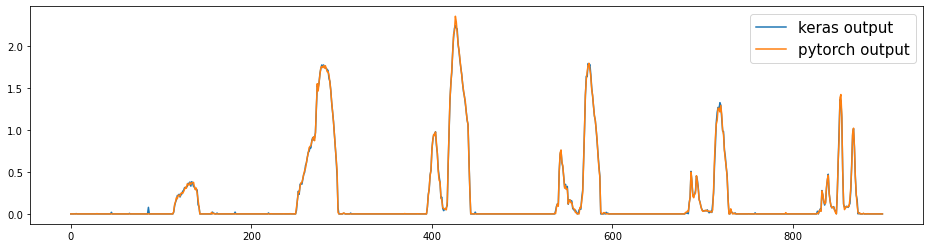

In [34]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

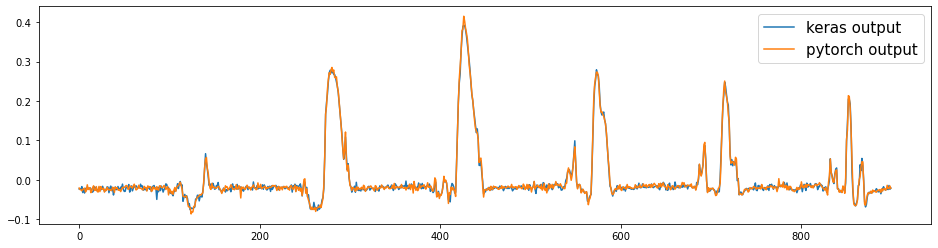

In [44]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,45],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,45],label='pytorch output')
plt.legend(fontsize=15)

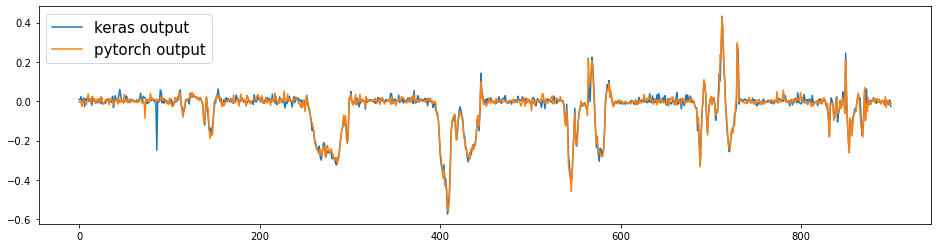

In [46]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,73],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,73],label='pytorch output')
plt.legend(fontsize=15)

In [35]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=1E-3)

In [36]:
a.shape

(13824, 113)

In [37]:
np.where(a==False)[0].size

816098

In [38]:
np.where(a==True)[0].size

746014

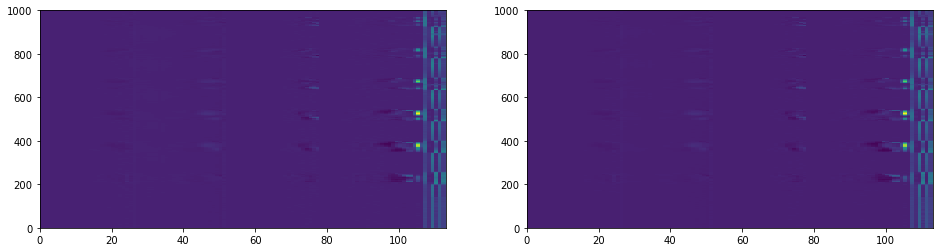

In [39]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])


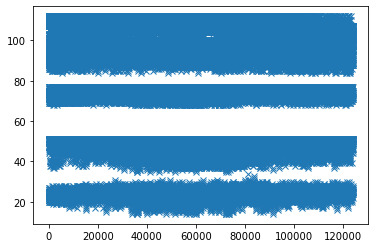

In [40]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-2)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [41]:
# save weights and biases 
to.save(Encoder_2,'real_geography/VEDs/VED_2/VEncoder_2_torch.pt')
to.save(Decoder_2,'real_geography/VEDs/VED_2/VDecoder_2_torch.pt')


In [42]:
# save Encoder 2 
enc_mod = to.jit.trace(Encoder_2, to.from_numpy(val_gen_II[300][0]))
to.jit.save(enc_mod,'real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 138200 / 138240 (100.0%)
Greatest absolute difference: 3.928394079208374 at index (13382, 6) (up to 1e-05 allowed)
Greatest relative difference: 5602.725318761384 at index (13078, 7) (up to 1e-05 allowed)
  _check_trace(


In [43]:
# save Decoder 2 
dec_mod = to.jit.trace(Decoder_2, Encoder_2(to.from_numpy(val_gen_II[300][0])))
to.jit.save(dec_mod,'real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad
